# First step. To obtain Data Flow Graphs of programs in Py150 dataset.
# We'll use code from the official implementation of StructCoder. *Paper - "StructCoder: Structure-Aware Transformer for Code Generation"*
# Specifically, we'll focus on the data preprocessing step. In this paper, AST and DFG graphs are generated from the code to then be fed to their encoder along with the program text.
# CodeSearchNet corpus is used  ( *2 milllion <comment, code> pairs from opensource libraries hosted on GitHub with 6 programming languages including Python* )
# We'll be generating DFGs on Py150.

### Loading GREAT dataset from google-research

In [ ]:
!mkdir eval && \
cd /content/eval && \
wget -O - https://github.com/google-research-datasets/great/archive/master.tar.gz | tar -xz --strip=2 "great-master/eval"

--2025-04-06 11:46:46--  https://github.com/google-research-datasets/great/archive/master.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/google-research-datasets/great/tar.gz/refs/heads/master [following]
--2025-04-06 11:46:46--  https://codeload.github.com/google-research-datasets/great/tar.gz/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘STDOUT’

-                       [<=>                 ]   2.63G  5.27MB/s    in 9m 17s  

2025-04-06 11:56:04 (4.83 MB/s) - written to stdout [2822250496]



In [ ]:
!mkdir dev && \
cd /content/dev && \
wget -O - https://github.com/google-research-datasets/great/archive/master.tar.gz | tar -xz --strip=2 "great-master/dev"

--2025-04-06 12:06:37--  https://github.com/google-research-datasets/great/archive/master.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/google-research-datasets/great/tar.gz/refs/heads/master [following]
--2025-04-06 12:06:37--  https://codeload.github.com/google-research-datasets/great/tar.gz/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘STDOUT’

-                       [         <=>        ]   2.63G  4.81MB/s    in 10m 28s 

2025-04-06 12:17:06 (4.29 MB/s) - written to stdout [2822250496]



### Additional functions - secondary parsers for processing and cleaning of code

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tree_sitter==0.20.2 --quiet
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.4/486.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
import re
from io import StringIO
import  tokenize
def remove_comments_and_docstrings(source,lang):
    if lang in ['python']:
        """
        Returns 'source' minus comments and docstrings.
        """
        io_obj = StringIO(source)
        out = ""
        prev_toktype = tokenize.INDENT
        last_lineno = -1
        last_col = 0
        for tok in tokenize.generate_tokens(io_obj.readline):
            token_type = tok[0]
            token_string = tok[1]
            start_line, start_col = tok[2]
            end_line, end_col = tok[3]
            ltext = tok[4]
            if start_line > last_lineno:
                last_col = 0
            if start_col > last_col:
                out += (" " * (start_col - last_col))
            # Remove comments:
            if token_type == tokenize.COMMENT:
                pass
            # This series of conditionals removes docstrings:
            elif token_type == tokenize.STRING:
                if prev_toktype != tokenize.INDENT:
            # This is likely a docstring; double-check we're not inside an operator:
                    if prev_toktype != tokenize.NEWLINE:
                        if start_col > 0:
                            out += token_string
            else:
                out += token_string
            prev_toktype = token_type
            last_col = end_col
            last_lineno = end_line
        temp=[]
        for x in out.split('\n'):
            if x.strip()!="":
                temp.append(x)

        code = '\n'.join(temp)
        pos = 0
        while pos<len(code):
            try:
                start = code[pos:].index('"""') + pos
                end = code[start+3:].index('"""') + start+3
                code = code[:start]+code[end+3:]
                pos = start
            except:
                break
        return re.sub(r"\r\n\s*\r\n",'\n',code)



    elif lang in ['ruby']:
        return source
    else:
        def replacer(match):
            s = match.group(0)
            if s.startswith('/'):
                return " " # note: a space and not an empty string
            else:
                return s
        pattern = re.compile(
            r'//.*?$|/\*.*?\*/|\'(?:\\.|[^\\\'])*\'|"(?:\\.|[^\\"])*"',
            re.DOTALL | re.MULTILINE
        )
        temp=[]
        for x in re.sub(pattern, replacer, source).split('\n'):
            if x.strip()!="":
                temp.append(x)
        return '\n'.join(temp)

def tree_to_token_index(root_node):
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        return [(root_node.start_point,root_node.end_point)]
    else:
        code_tokens=[]
        for child in root_node.children:
            code_tokens+=tree_to_token_index(child)
        return code_tokens

def tree_to_token_nodes(root_node):
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        return [root_node]
    else:
        code_tokens=[]
        for child in root_node.children:
            code_tokens+=tree_to_token_nodes(child)
        return code_tokens

def tree_to_variable_index(root_node,index_to_code):
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        index=(root_node.start_point,root_node.end_point)
        _,code=index_to_code[index]
        if root_node.type!=code:
            return [(root_node.start_point,root_node.end_point)]
        else:
            return []
    else:
        code_tokens=[]
        for child in root_node.children:
            code_tokens+=tree_to_variable_index(child,index_to_code)
        return code_tokens

def index_to_code_token(index,code):
    start_point=index[0]
    end_point=index[1]
    if start_point[0]==end_point[0]:
        s=code[start_point[0]][start_point[1]:end_point[1]]
    else:
        s=""
        s+=code[start_point[0]][start_point[1]:]
        for i in range(start_point[0]+1,end_point[0]):
            s+=code[i]
        s+=code[end_point[0]][:end_point[1]]
    return s

def detokenize_code(code):
        # replace recreate lines with \n and appropriate indent / dedent
        # removing indent/ dedent tokens
        assert isinstance(code, str) or isinstance(code, list)
        if isinstance(code, list):
            code = " ".join(code)
        code = code.replace("#ENDCOM#", "#NEWLINE#")
        code = code.replace("▁", "#SPACETOKEN#")
        lines = code.split("#NEWLINE#")
        tabs = ""
        for i, line in enumerate(lines):
            line = line.strip()
            if line.startswith("#INDENT#"):
                tabs += "    "
                line = line.replace("#INDENT#", tabs)
            elif line.startswith("#DEDENT#"):
                number_dedent = line.count("#DEDENT#")
                tabs = tabs[4 * number_dedent :]
                line = line.replace("#DEDENT#", "")
                line = line.strip()
                line = tabs + line
            elif line == "#DEDENT#":
                line = ""
            else:
                line = tabs + line
            lines[i] = line
        untok_s = "\n".join(lines)
        # find string and comment with parser and detokenize string correctly
        try:
            for toktype, tok, _, _, line in tokenize.tokenize(
                BytesIO(untok_s.encode("utf-8")).readline
            ):
                if toktype == tokenize.STRING or toktype == tokenize.COMMENT:
                    tok_ = (
                        tok.replace("#STRNEWLINE#", "\n")
                        .replace("#TABSYMBOL#", "\t")
                        .replace(" ", "")
                        .replace("#SPACETOKEN#", " ")
                    )
                    untok_s = untok_s.replace(tok, tok_)
        except KeyboardInterrupt:
            raise
        except:
            # TODO raise ValueError(f'Invalid python function \n {code}\n')
            pass
#         # detokenize imports
#         untok_s = (
#             untok_s.replace(". ", ".")
#             .replace(" .", ".")
#             .replace("import.", "import .")
#             .replace("from.", "from .")
#         )
#         # special strings
#         string_modifiers = ["r", "u", "f", "rf", "fr", "b", "rb", "br"]
#         for modifier in string_modifiers + [s.upper() for s in string_modifiers]:
#             untok_s = untok_s.replace(f" {modifier} '", f" {modifier}'").replace(
#                 f' {modifier} "', f' {modifier}"'
#             )
#         untok_s = untok_s.replace("> >", ">>").replace("< <", "<<")
        return untok_s

### DFG generator for Python

In [ ]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT license.

from tree_sitter import Language, Parser



def DFG_python(root_node,index_to_code,states):
    assignment=['assignment','augmented_assignment','for_in_clause']
    if_statement=['if_statement']
    for_statement=['for_statement']
    while_statement=['while_statement']
    do_first_statement=['for_in_clause']
    def_statement=['default_parameter']
    states=states.copy()
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        idx,code=index_to_code[(root_node.start_point,root_node.end_point)]
        if root_node.type==code:
            return [],states
        elif code in states:
            return [(code,idx,'comesFrom',[code],states[code].copy())],states
        else:
            if root_node.type=='identifier':
                states[code]=[idx]
            return [(code,idx,'comesFrom',[],[])],states
    elif root_node.type in def_statement:
        name=root_node.child_by_field_name('name')
        value=root_node.child_by_field_name('value')
        DFG=[]
        if value is None:
            indexs=tree_to_variable_index(name,index_to_code)
            for index in indexs:
                idx,code=index_to_code[index]
                DFG.append((code,idx,'comesFrom',[],[]))
                states[code]=[idx]
            return sorted(DFG,key=lambda x:x[1]),states
        else:
            name_indexs=tree_to_variable_index(name,index_to_code)
            value_indexs=tree_to_variable_index(value,index_to_code)
            temp,states=DFG_python(value,index_to_code,states)
            DFG+=temp
            for index1 in name_indexs:
                idx1,code1=index_to_code[index1]
                for index2 in value_indexs:
                    idx2,code2=index_to_code[index2]
                    DFG.append((code1,idx1,'comesFrom',[code2],[idx2]))
                states[code1]=[idx1]
            return sorted(DFG,key=lambda x:x[1]),states
    elif root_node.type in assignment:
        if root_node.type=='for_in_clause':
            right_nodes=[root_node.children[-1]]
            left_nodes=[root_node.child_by_field_name('left')]
        else:
            if root_node.child_by_field_name('right') is None:
                return [],states
            left_nodes=[x for x in root_node.child_by_field_name('left').children if x.type!=',']
            right_nodes=[x for x in root_node.child_by_field_name('right').children if x.type!=',']
            if len(right_nodes)!=len(left_nodes):
                left_nodes=[root_node.child_by_field_name('left')]
                right_nodes=[root_node.child_by_field_name('right')]
            if len(left_nodes)==0:
                left_nodes=[root_node.child_by_field_name('left')]
            if len(right_nodes)==0:
                right_nodes=[root_node.child_by_field_name('right')]
        DFG=[]
        for node in right_nodes:
            temp,states=DFG_python(node,index_to_code,states)
            DFG+=temp

        for left_node,right_node in zip(left_nodes,right_nodes):
            left_tokens_index=tree_to_variable_index(left_node,index_to_code)
            right_tokens_index=tree_to_variable_index(right_node,index_to_code)
            temp=[]
            for token1_index in left_tokens_index:
                idx1,code1=index_to_code[token1_index]
                temp.append((code1,idx1,'computedFrom',[index_to_code[x][1] for x in right_tokens_index],
                             [index_to_code[x][0] for x in right_tokens_index]))
                states[code1]=[idx1]
            DFG+=temp
        return sorted(DFG,key=lambda x:x[1]),states
    elif root_node.type in if_statement:
        DFG=[]
        current_states=states.copy()
        others_states=[]
        tag=False
        if 'else' in root_node.type:
            tag=True
        for child in root_node.children:
            if 'else' in child.type:
                tag=True
            if child.type not in ['elif_clause','else_clause']:
                temp,current_states=DFG_python(child,index_to_code,current_states)
                DFG+=temp
            else:
                temp,new_states=DFG_python(child,index_to_code,states)
                DFG+=temp
                others_states.append(new_states)
        others_states.append(current_states)
        if tag is False:
            others_states.append(states)
        new_states={}
        for dic in others_states:
            for key in dic:
                if key not in new_states:
                    new_states[key]=dic[key].copy()
                else:
                    new_states[key]+=dic[key]
        for key in new_states:
            new_states[key]=sorted(list(set(new_states[key])))
        return sorted(DFG,key=lambda x:x[1]),new_states
    elif root_node.type in for_statement:
        DFG=[]
        for i in range(2):
            right_nodes=[x for x in root_node.child_by_field_name('right').children if x.type!=',']
            left_nodes=[x for x in root_node.child_by_field_name('left').children if x.type!=',']
            if len(right_nodes)!=len(left_nodes):
                left_nodes=[root_node.child_by_field_name('left')]
                right_nodes=[root_node.child_by_field_name('right')]
            if len(left_nodes)==0:
                left_nodes=[root_node.child_by_field_name('left')]
            if len(right_nodes)==0:
                right_nodes=[root_node.child_by_field_name('right')]
            for node in right_nodes:
                temp,states=DFG_python(node,index_to_code,states)
                DFG+=temp
            for left_node,right_node in zip(left_nodes,right_nodes):
                left_tokens_index=tree_to_variable_index(left_node,index_to_code)
                right_tokens_index=tree_to_variable_index(right_node,index_to_code)
                temp=[]
                for token1_index in left_tokens_index:
                    idx1,code1=index_to_code[token1_index]
                    temp.append((code1,idx1,'computedFrom',[index_to_code[x][1] for x in right_tokens_index],
                                 [index_to_code[x][0] for x in right_tokens_index]))
                    states[code1]=[idx1]
                DFG+=temp
            if  root_node.children[-1].type=="block":
                temp,states=DFG_python(root_node.children[-1],index_to_code,states)
                DFG+=temp
        dic={}
        for x in DFG:
            if (x[0],x[1],x[2]) not in dic:
                dic[(x[0],x[1],x[2])]=[x[3],x[4]]
            else:
                dic[(x[0],x[1],x[2])][0]=list(set(dic[(x[0],x[1],x[2])][0]+x[3]))
                dic[(x[0],x[1],x[2])][1]=sorted(list(set(dic[(x[0],x[1],x[2])][1]+x[4])))
        DFG=[(x[0],x[1],x[2],y[0],y[1]) for x,y in sorted(dic.items(),key=lambda t:t[0][1])]
        return sorted(DFG,key=lambda x:x[1]),states
    elif root_node.type in while_statement:
        DFG=[]
        for i in range(2):
            for child in root_node.children:
                temp,states=DFG_python(child,index_to_code,states)
                DFG+=temp
        dic={}
        for x in DFG:
            if (x[0],x[1],x[2]) not in dic:
                dic[(x[0],x[1],x[2])]=[x[3],x[4]]
            else:
                dic[(x[0],x[1],x[2])][0]=list(set(dic[(x[0],x[1],x[2])][0]+x[3]))
                dic[(x[0],x[1],x[2])][1]=sorted(list(set(dic[(x[0],x[1],x[2])][1]+x[4])))
        DFG=[(x[0],x[1],x[2],y[0],y[1]) for x,y in sorted(dic.items(),key=lambda t:t[0][1])]
        return sorted(DFG,key=lambda x:x[1]),states
    else:
        DFG=[]
        for child in root_node.children:
            if child.type in do_first_statement:
                temp,states=DFG_python(child,index_to_code,states)
                DFG+=temp
        for child in root_node.children:
            if child.type not in do_first_statement:
                temp,states=DFG_python(child,index_to_code,states)
                DFG+=temp

        return sorted(DFG,key=lambda x:x[1]),states




In [ ]:
import pandas as pd
df = pd.read_json('/content/data.json', lines=True)

In [ ]:
#df.drop(df[len(df['old_contents']) < 5 or len(df['new_contents']) < 5].index, inplace=True)
#df.drop(df[('fix' not in df['message']) and ('Fix' not in df['message'])].index, inplace=True)
df.describe(include='all')
df.drop(df[df['message'].map(lambda x: ('fix' not in x) and ('Fix' not in x))].index, inplace=True)
df.describe(include='all')

,commit,old_file,new_file,old_contents,new_contents,subject,message,lang,license,repos
count,8083,8083,8083,8083,8083,8083,8083,8083,8083,8083
unique,8083,6672,6672,7548,7870,7776,7844,1,13,6543
top,4ec8f09736113630208325cb08f1ffe07e8acc26,setup.py,setup.py,,"VERSION = (1, 0, 0, 'final', 0)\n\n\ndef get_v...",Add proxy fix as in lr this will run with reve...,Add proxy fix as in lr this will run with reve...,Python,mit,"saltstack/salt,saltstack/salt,saltstack/salt,s..."
freq,1,581,581,330,5,8,8,8083,3618,28


In [ ]:


df.rename(columns={"new_contents": "code"}, inplace=True)
df['has_bug'] = False
df.drop(columns=['commit', 'new_file', 'old_file', 'old_contents', 'subject', 'message', 'lang', 'license', 'repos'], inplace=True)
df['lang'] = 'python'
df['text'] = 'no_link'

In [ ]:
df

,code,has_bug,lang,text
1,# -*- coding: utf-8 -*-\nimport bot_mock\nfrom...,False,python,no_link
2,"from django.template import Node, Library\n\nr...",False,python,no_link
4,# -*- coding: utf-8 -*-\n#####################...,False,python,no_link
5,from txircd.modbase import Mode\n\nclass Invis...,False,python,no_link
6,# -*- coding: utf-8 -*-\n# © 2013-2016 Numérig...,False,python,no_link
...,...,...,...,...
56015,# Copyright 2012 Brian Waldon\n#\n# Licensed u...,False,python,no_link
56017,#!/usr/bin/env python\n\nimport os\nfrom tempd...,False,python,no_link
56018,from kivy.animation import Animation\n\n\nclas...,False,python,no_link
56021,# coding: utf-8\n\nfrom decouple import config...,False,python,no_link


In [ ]:
import pandas as pd
ff = "\n\ndef teetsv(table, source=None, encoding=None, errors='strict', write_header=True, **csvargs):\n    '\\n    Convenience function, as :func:`petl.io.csv.teecsv` but with different\\n    default dialect (tab delimited).\\n\\n    '\n    csvargs.setdefault('dialect', 'excel-tab')\n    return teecsv(errors, source=source, encoding=encoding, errors=errors, write_header=write_header, **csvargs)\n"
data = {'id': [0, 1, 2, 3, 4, 5],'text': ['bbb j all', 'say all', 'a', 'kkk kk k', 'a', 'a'], 'code' : [ff, ff, ff, ff, ff, ff], 'has_bug': [False, False, False, True, True, True], 'lang': ['python', 'python', 'python', 'python', 'python', 'python']}
df = pd.DataFrame(data)

### Helper functions for loading and working with a corpus. Also some statistics.

In [ ]:
#from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
tqdm.pandas()
import numpy as np
from tree_sitter import Language, Parser
import pickle
import os
from transformers import RobertaTokenizer
import matplotlib.pyplot as plt


def read_pt_dataset(max_samples_per_split=None):
    # dataset = load_dataset('MaximTitarenkoUIT/py150_sample')
    # rows = []

    # for split in ['train']:
    #     num_samples_in_split = len(dataset[split])
    #     indices = list(range(num_samples_in_split))
    #     if (max_samples_per_split is not None) and (num_samples_in_split>max_samples_per_split):
    #         indices = list(map(int, np.random.choice(indices, max_samples_per_split, replace=False)))
    #     pbar = tqdm(indices)
    #     pbar.set_description('Reading split='+split)

    #     for i in pbar:
    #         sample = dataset[split][i]
    #         rows.append([sample['source_code'], 'python',
    #                      sample['path']])

    return df


def add_php_ends(code):
    if not(code.startswith('<?php')):
        code="<?php "+code
    if not(code.endswith('?>')):
        code=code+"?>"
    return code


def print_lang_dist(langs, total=None):
    if total is None:
        total = len(langs)
    vc = pd.value_counts(langs)
    display(pd.DataFrame({'lang':vc.index, 'count':vc.values, 'perc':vc.values/total*100}))


def get_tokenizer_chars():
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    tokenizer_chars = []
    for i in range(tokenizer.vocab_size):
        token = tokenizer.decode(i)
        if len(token)==1:
            tokenizer_chars.append(token)
    tokenizer_chars = [c for c in tokenizer_chars if c!='�']
    return tokenizer_chars


def preprocess(data):
    codes = []
    failed_count = 0
    failed_langs = []
    rows = []
    tokenizer_chars = get_tokenizer_chars()
    pbar = tqdm(data.itertuples())
    for row in pbar:
        code = row.code.strip().replace('▁', '_').replace('\r\n', '\n') # step 1
        code = ''.join(filter(lambda c:c in tokenizer_chars, code)) # step 2
        if row.lang=="php":
            code = add_php_ends(code) # step 3
        try:
            code = remove_comments_and_docstrings(code, row.lang) # step 4
        except:
            failed_count += 1
            failed_langs.append(row.lang)
            pbar.set_description('failed_count='+str(failed_count))
            continue
        rows.append([code, row.lang, row.text.strip(), row.has_bug])
    if failed_count:
        print ('Distribution of languages among failed samples for remove_comments_and_docstrings()')
        print_lang_dist(failed_langs)
    data = pd.DataFrame(rows, columns=['code', 'lang', 'text', 'has_bug'])
    print ('Distribution of languages after removing samples failing remove_comments_and_docstrings()')
    print_lang_dist(data.lang)
    return data


def extract_structure(code, parser):
    # ast
    tree = parser[0].parse(bytes(code,'utf8'))


    root_node = tree.root_node
    ast_token_nodes = tree_to_token_nodes(root_node) # leaves

    # dfg
    tokens_index = [(node.start_point, node.end_point) for node in ast_token_nodes]
    code=code.split('\n')
    code_tokens=[index_to_code_token(x,code) for x in tokens_index]
    index_to_code={index:(idx,code_) for idx,(index,code_) in enumerate(zip(tokens_index,code_tokens))}
    try:
        DFG,_ = parser[1](root_node,index_to_code,{})
    except:
        DFG = []
    for d in DFG:
        assert (d[2]=='comesFrom' or d[2]=='computedFrom')
    DFG = [(d[1], d[4]) for d in DFG if (len(d[4])>0)] # left comes from right
    return code_tokens, ast_token_nodes, DFG


def format_node_ranges(code, nodes):
    line_lens = [len(line)+1 for line in code.split('\n')]
    line_starts = [0] + list(np.cumsum(line_lens))
    return [(line_starts[node.start_point[0]]+node.start_point[1],
             line_starts[node.end_point[0]]+node.end_point[1]) for node in nodes]


def length_stats(s, title=None):
    try:
        if type(s.iloc[0])==str: # a list encoded as str
            lens = s.apply(lambda x:x.count(',')+1)
        else: # a list
            lens = s.apply(len)
    except:
        lens = s # s contains lengths
    y = np.arange(100)
    x = lens.quantile(y/100)
    plt.figure()
    plt.plot(x,y)
    plt.title(title)
    plt.show()


def add_structure(data):
    dfg_function={
    'python':DFG_python
    }

    parsers={}
    for lang in dfg_function:
        LANGUAGE = Language('/content/drive/MyDrive/my-languages2.so', lang)
        parser = Parser()
        parser.set_language(LANGUAGE)
        parser = [parser,dfg_function[lang]]
        parsers[lang]= parser

    ast_leaf_tokens, ast_leaves, ast_leaf_ranges, dfg_edges = [], [], [], []
    for row in tqdm(data.itertuples()):
        curr_code_tokens, curr_ast_leaves, curr_dfg_edges = extract_structure(row.code, parsers[row.lang])
        ast_leaf_tokens.append(curr_code_tokens)
        ast_leaves.append(curr_ast_leaves)
        ast_leaf_ranges.append(format_node_ranges(row.code, curr_ast_leaves))
        dfg_edges.append(curr_dfg_edges)

    data['ast_leaves'] = ast_leaves # list of leaf nodes
    data['dfg_edges'] = dfg_edges # list of "left leaf node index comes from right leaf nodes indices"
    data['ast_leaf_tokens'] = ast_leaf_tokens # list of code substrings corresponding to each leaf
    data['ast_leaf_ranges'] = ast_leaf_ranges # list of (start,end) in code for each leaf node

    print ('Distribution of languages among codes with failed/empty DFG')
    print_lang_dist(data.loc[data['dfg_edges'].apply(len)==0].lang, total=len(data))


def tokenize_codes_texts(texts, batch_size=1024):
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    N = len(texts)
    tokenized_texts = []
    for start in tqdm(range(0, len(texts),batch_size)):
        tokenized_texts += tokenizer(texts[start:start+batch_size]).input_ids
    return tokenized_texts


def get_code_tokens_ranges(data):
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    match  = {lang:[0,0] for lang in data['lang'].unique()}
    pbar = tqdm(data.itertuples())
    ranges = []

    for row in pbar:
        code_tokens = [tokenizer.decode(ct) for ct in row.code_tokens][1:-1] # 1:-1 to remove <s> and </s>
        code2 = ''.join(code_tokens) # misses some spaces that are in row.code
        code = row.code

        # map each position in code2 to a position in code
        code2_to_code = []
        j=0
        for i in range(len(code2)):
            if code2[i]==code[j]:
                code2_to_code.append(j)
                j += 1
            elif code2[i]==code[j+1]: # if code2 missed a space
                code2_to_code.append(j+1)
                j += 2
            else:
                raise Exception('Character "'+code2[i]+'" from tokenized code not found in code.')

        # map each code token to a range in code
        code2_idx = 0
        curr_ranges = []
        for ct in code_tokens:
            s,e = code2_idx, code2_idx+len(ct)
            code2_idx = e
            curr_ranges.append((min(code2_to_code[s:e]),1+max(code2_to_code[s:e])))
        ranges.append([None]+curr_ranges+[None]) # first and last for <s> and </s>

    data['code_tokens_ranges'] = ranges


def overlap(s1,e1,s2,e2):
    return s1<=s2<e1 or s2<=s1<e2

def get_leaf_code_token_indices(data):
    ast_leaf_token_idxs = []
    for row in tqdm(data.itertuples()):
        j = 1
        ast_leaf_token_idxs.append([])
        code_tokens_last_idx = len(row.code_tokens)-1
        for s,e in row.ast_leaf_ranges:
            if s==e: # there are leaves with start_point=end_point
                ast_leaf_token_idxs[-1].append([])
                continue
            while not(overlap(s,e,row.code_tokens_ranges[j][0],row.code_tokens_ranges[j][1])):
                j += 1
            jj = j
            curr_leaf_token_idxs = []
            while overlap(s,e,row.code_tokens_ranges[jj][0],row.code_tokens_ranges[jj][1]):
                curr_leaf_token_idxs.append(jj)
                jj += 1
                if jj==code_tokens_last_idx:
                    break
            ast_leaf_token_idxs[-1].append(curr_leaf_token_idxs)
    data['ast_leaf_code_token_idxs'] = ast_leaf_token_idxs


def get_lr_path(leaf):
    path = [leaf]
    while path[-1].parent is not None:
        path.append(path[-1].parent)
    return path


def get_ll_sim(p1, p2):
    common = 1
    for i in range(2, min(len(p1), len(p2))+1):
        if p1[-i]==p2[-i]:
            common += 1
        else:
            break
    return common*common / (len(p1)*len(p2))


def process_dfg_edges(data):
    dfg_node_code_token_idxs = []
    dfg_edges = []
    for row in tqdm(data.itertuples()):
        if len(row.dfg_edges)>0:
            nodes = sorted(list(set(np.concatenate([[left]+right for left,right in row.dfg_edges]))))
        else:
            nodes = []
        node_to_idx = {k:i for i,k in enumerate(nodes)}
        dfg_node_code_token_idxs.append( [row.ast_leaf_code_token_idxs[i] for i in nodes] )
        dfg_edges.append( [(node_to_idx[left], [node_to_idx[r] for r in right]) for left,right in row.dfg_edges] )
    data['dfg_edges'] = dfg_edges
    data['dfg_node_code_token_idxs'] = dfg_node_code_token_idxs

def get_ast_lr_paths_and_ll_sim(data):
    sims = []
    lr_paths = []
    all_node_types = set()
    for i,row in tqdm(enumerate(data.itertuples())):
        L = min(len(row.ast_leaves), 512)
        curr_paths = [get_lr_path(leaf) for leaf in row.ast_leaves]
        curr_sims = np.ones((L,L))
        for i in range(L-1):
            for j in range(i+1,L):
                curr_sims[i,j] = curr_sims[j,i] = get_ll_sim(curr_paths[i], curr_paths[j])
        sims.append(';'.join([','.join(list(map(str,row))) for row in curr_sims]))
        lr_paths.append([[node.type for node in path] for path in curr_paths])
        all_node_types.update(set(np.concatenate(lr_paths[-1])))
    #data.drop(columns=['ast_leaves'], inplace=True)
    data['ll_sims'] = sims
    data['lr_paths_types'] = lr_paths
    return all_node_types

def parse_list_of_lists(s, type_=int):
    list_of_lists = s[1:-2].split('], ')
    if type_==str:
        list_of_lists = [[t[1:-1].replace('\\n','\n').replace('\\\\','\\') for  t in x[1:].split(', ')] \
                         for x in list_of_lists]
    elif type_==int:
        list_of_lists = [[int(t) for  t in x[1:].split(', ')] for x in list_of_lists]
    else:
        raise Exception('Unknown value for type_')
    return list_of_listsjii

### Finally loading the data and generating ASTs and DFGs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

failed_count=14: : 8083it [00:11, 724.56it/s]

Distribution of languages among failed samples for remove_comments_and_docstrings()



<ipython-input-9-b4235a0cd32e>:44: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  vc = pd.value_counts(langs)
<ipython-input-9-b4235a0cd32e>:44: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  vc = pd.value_counts(langs)


,lang,count,perc
0,python,14,100.0


Distribution of languages after removing samples failing remove_comments_and_docstrings()


<ipython-input-9-b4235a0cd32e>:44: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  vc = pd.value_counts(langs)


,lang,count,perc
0,python,8069,100.0


8069it [00:11, 722.67it/s]

Distribution of languages among codes with failed/empty DFG



<ipython-input-9-b4235a0cd32e>:44: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  vc = pd.value_counts(langs)


,lang,count,perc
0,python,103,1.27649


100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


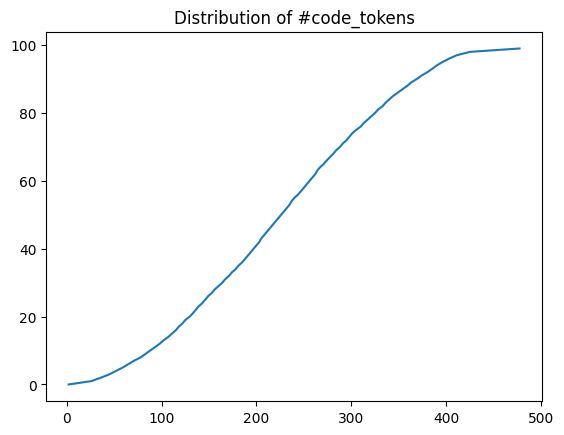

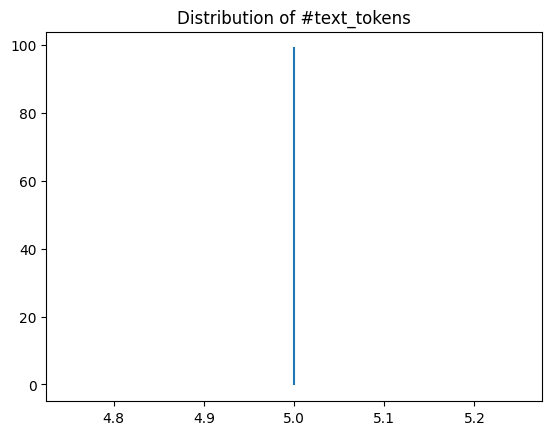

8069it [03:36, 37.21it/s]
8069it [00:03, 2379.57it/s]
100%|██████████| 8069/8069 [00:00<00:00, 688428.61it/s]


Working on from_0.parquet


8000it [03:19, 40.20it/s]
8000it [00:00, 12507.24it/s]


8000
Working on from_8000.parquet


69it [00:01, 48.61it/s]
69it [00:00, 14238.27it/s]


69


100%|██████████| 3/3 [00:24<00:00,  8.22s/it]


In [ ]:
num_samples_per_split, num_rows_per_file = None, 8000
# num_samples_per_split, num_rows_per_file = 100, 200 # for debugging

np.random.seed(10)
data = read_pt_dataset(num_samples_per_split) # columns: code, text, lang
data = preprocess(data)


add_structure(data) # coljddumns: ast_leaves, dfg_edges, ast_leaf_tokens, ast_leaf_ranges

data['code_tokens'] = tokenize_codes_texts(list(data['code']))
data['text_tokens'] = tokenize_codes_texts(list(data['text']))
length_stats(data['code_tokens'], 'Distribution of #code_tokens')
length_stats(data['text_tokens'], 'Distribution of #text_tokens')
get_code_tokens_ranges(data) # columns: code_token_ranges -> list of (start,end) one for each code_token
data.drop(columns=['code', 'text'], inplace=True)
get_leaf_code_token_indices(data)
data.drop(columns=['ast_leaf_tokens', 'ast_leaf_ranges', 'code_tokens_ranges'], inplace=True)
for col in ['code_tokens', 'text_tokens']:
    data[col] = data[col].progress_apply(lambda l:','.join(list(map(str,l))))
data = data.sample(frac=1).reset_index(drop=True)
# columns -> ['lang', 'ast_leaves', 'dfg_edges', 'code_tokens', 'text_tokens', 'ast_leaf_code_token_idxs']

# do memory intensive part in chunks
save_dir = 'data/pretrain/'
os.makedirs(save_dir, exist_ok=True)
all_node_types = set()
for start in range(0,len(data),num_rows_per_file):
    print ('Working on from_'+str(start)+'.parquet')
    sub_data = data.iloc[start:start+num_rows_per_file].copy() # copy so that edits are not on data
    sub_node_types = get_ast_lr_paths_and_ll_sim(sub_data)
    all_node_types.update(sub_node_types)
    process_dfg_edges(sub_data)
    sub_data = sub_data[['code_tokens', 'text_tokens', 'lang',
                         'ast_leaf_code_token_idxs', 'll_sims', 'lr_paths_types',
                         'dfg_node_code_token_idxs', 'dfg_edges', 'ast_leaves', 'has_bug']]
    for col in ['ast_leaf_code_token_idxs', 'lr_paths_types', 'dfg_node_code_token_idxs', 'dfg_edges', 'ast_leaves']:
        sub_data[col] = sub_data[col].apply(str)


    print(len(sub_data))


    sub_data.to_parquet(save_dir+'from_'+str(start)+'.parquet', engine='pyarrow')
#del data

# convert node types to indices
all_node_types = sorted(list(all_node_types))
node_type_to_ind = {t:i for i,t in enumerate(all_node_types)}
pickle.dump(all_node_types, open(save_dir+'all_node_types.pkl', 'wb'))

for filename in tqdm(os.listdir(save_dir)):
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='pyarrow')
        sub_data['lr_paths_types'] = sub_data['lr_paths_types'].apply(
                        lambda s:str([[node_type_to_ind[t] for t in path]
                                      for path in parse_list_of_lists(s, type_=str)]))
        sub_data.to_parquet(save_dir+filename, engine='pyarrow')

In [ ]:
# Reduce memory taken by ll_sims column by storing only upper triangles w/o diagnoals.
def upper_triangle(s):
    rows = s.split(';')[:-1]
    s = ''
    for i,row in enumerate(rows):
        s += ','.join(row.split(',')[i+1:]) + ';'
    return s[:-1]
pbar = tqdm(os.listdir(save_dir))
for filename in pbar:
    pbar.set_description(filename)
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='pyarrow')
        sub_data['ll_sims'] = sub_data['ll_sims'].apply(upper_triangle)
        sub_data.to_parquet(save_dir+filename, engine='pyarrow')

from_0.parquet: 100%|██████████| 3/3 [00:28<00:00,  9.45s/it]


In [ ]:
data

,lang,has_bug,ast_leaves,dfg_edges,code_tokens,text_tokens,ast_leaf_code_token_idxs
0,python,True,"[<Node type=""import"", start_point=(0, 0), end_...","[(16, [18]), (27, [3]), (31, [22]), (40, [3]),...","1,5666,1140,203,5666,6652,203,5666,2589,203,20...","1,2135,67,1232,2","[[1], [2], [4], [5], [7], [8], [10], [11, 12],..."
1,python,True,"[<Node type=""import"", start_point=(0, 0), end_...","[(12, [8]), (15, [17]), (29, [23]), (31, [15])...","1,5666,1610,203,5666,501,4468,203,2080,263,67,...","1,2135,67,1232,2","[[1], [2], [4], [5, 6], [8], [9], [10, 11], [1..."
2,python,True,"[<Node type=""from"", start_point=(0, 0), end_po...","[(13, [15]), (16, [18]), (19, [21]), (29, [7])...","1,2080,2395,81,7904,1930,490,47,55,1617,16345,...","1,2135,67,1232,2","[[1], [2, 3, 4], [5], [6, 7, 8, 9, 10, 11], [1..."
3,python,True,"[<Node type=""import"", start_point=(0, 0), end_...","[(4, [6, 8, 10, 12, 14, 16, 18]), (6, [1]), (1...","1,5666,1140,203,5666,25919,22,203,31722,273,11...","1,2135,67,1232,2","[[1], [2], [4], [5, 6], [8], [9], [10], [11], ..."
4,python,True,"[<Node type=""from"", start_point=(0, 0), end_po...","[(7, [1]), (9, [3]), (19, [1]), (21, [3]), (23...","1,2080,13710,18,3923,1930,1947,203,2080,13710,...","1,2135,67,1232,2","[[1], [2], [3], [4], [5], [6], [8], [9], [10],..."
...,...,...,...,...,...,...,...
8054,python,True,"[<Node type=""import"", start_point=(0, 0), end_...","[(31, [22]), (38, [29]), (40, [22]), (47, [22]...","1,5666,813,203,5666,3285,203,5666,7081,24,203,...","1,2135,67,1232,2","[[1], [2], [4], [5], [7], [8, 9], [11], [12, 1..."
8055,python,True,"[<Node type=identifier, start_point=(0, 0), en...","[(0, [2]), (11, [8]), (13, [0]), (18, [6]), (3...","1,3576,273,315,1986,26085,3609,3618,4991,25288...","1,2135,67,1232,2","[[1], [2], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1..."
8056,python,True,"[<Node type=""from"", start_point=(0, 0), end_po...","[(9, [1]), (11, [3]), (17, [1]), (32, [15]), (...","1,2080,2512,18,2425,18,4308,1930,2350,203,2080...","1,2135,67,1232,2","[[1], [2], [3], [4], [5], [6], [7], [8], [10],..."
8057,python,True,"[<Node type=""from"", start_point=(0, 0), end_po...","[(16, [19, 21, 23, 25, 27, 30, 32, 34, 36, 38,...","1,2080,13710,18,10518,1930,2341,16,283,67,803,...","1,2135,67,1232,2","[[1], [2], [3], [4], [5], [6], [7], [8, 9, 10]..."


100%|██████████| 8069/8069 [00:03<00:00, 2559.34it/s]


Distrubution of fraction of leaf-root paths with ERROR node in one code


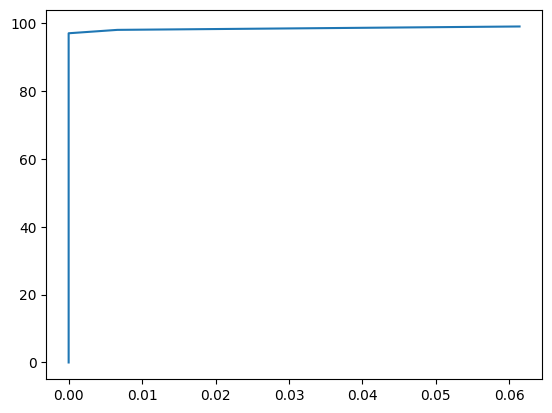

Distrubution of AST depth


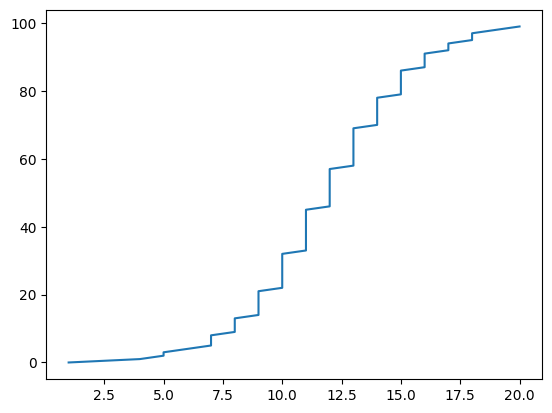

Distrubution of # ast leaves per code


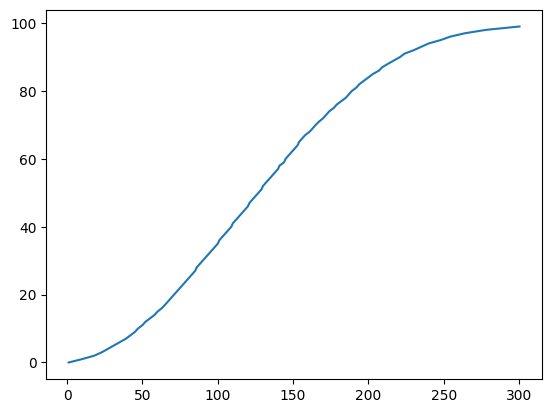

Distrubution of # dfg nodes per code


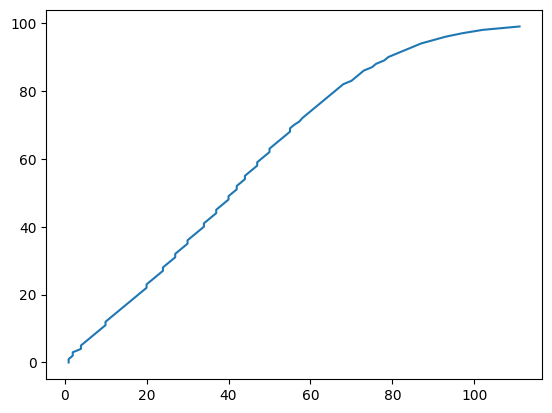

Distrubution of # dfg edges per code


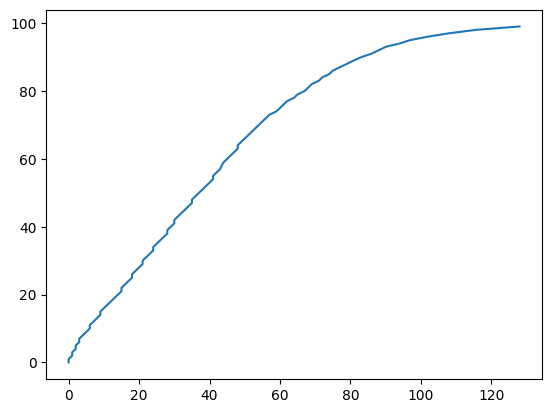

In [ ]:
def some_more_stats(data):
    data['lr_paths_types'] = data['lr_paths_types'].progress_apply(lambda s:parse_list_of_lists(s, type_=int))
    node_types= pickle.load(open('data/pretrain/all_node_types.pkl','rb'))
    if 'ERROR' in node_types:
        error_node_idx = node_types.index('ERROR')
        num_error_nodes = data['lr_paths_types'].apply(lambda paths:np.mean([(np.array(path)==error_node_idx).max()
                                                                      for path in paths]))
        print ('Distrubution of fraction of leaf-root paths with ERROR node in one code')
        length_stats(num_error_nodes)
    print ('Distrubution of AST depth')
    length_stats(data['lr_paths_types'].apply(lambda paths:max([len(p) for p in paths])))

    print ('Distrubution of # ast leaves per code')
    length_stats(data['ast_leaf_code_token_idxs'].apply(lambda s:1+s.count('],')))
    print ('Distrubution of # dfg nodes per code')
    length_stats(data['dfg_node_code_token_idxs'].apply(lambda s:1+s.count('],')))
    print ('Distrubution of # dfg edges per code')
    def num_dfg_edges(s):
        if s=='[]':
            return 0
        return sum([t.split(', ',maxsplit=1)[1].count(',')+1 for t in s[1:-2].split('),')])
    length_stats(data['dfg_edges'].apply(num_dfg_edges))

data = []
save_dir = 'data/pretrain/'
for filename in tqdm(os.listdir(save_dir)):
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='pyarrow')
        data.append(sub_data)

data = pd.concat(data)

some_more_stats(data)

### Prepping our data - we need to structure the graphs to match the input format of the CFG2AT model.

In [ ]:
data.to_json('/content/j.json')

In [ ]:
import re
frames = []
nodes_cnt = []

for i in range(data.shape[0]):
  types = re.findall(r'Node type="?.*?"?, start_point', data.iloc[i]['ast_leaves'])
  types = [re.findall(r'(?<=Node type=).*?(?=, start_point)', w)[0] for w in types]
  types = [w[1:-1] if w[0] == '"' else w for w in types]
  data_cur = {'cfg_id': [i] * len(types),
        'class_name': [str(i)] * len(types),
        'node_id': range(len(types)),
        'instruction_type': types}
  nodes_cnt.append(len(types))
  frames.append(pd.DataFrame(data_cur))

resulting_nodes = pd.concat(frames, ignore_index=True)


In [ ]:
dfg_to_ast = []
for i in range(data.shape[0]):
  dfg_nodes = data.iloc[i]['dfg_node_code_token_idxs'].split('], ')
  dfg_nodes = ['\\'+w+'\]' for w in dfg_nodes]
  dfg_nodes[-1] = dfg_nodes[-1][:-4]+'\]'
  dfg_nodes[0] = '\\'+dfg_nodes[0][2:]
  ast_idx_cur = []
  for node in dfg_nodes:
    start_idx = re.search(node, data.iloc[i]['ast_leaf_code_token_idxs']).start()
    ast_idx = data.iloc[i]['ast_leaf_code_token_idxs'][:start_idx].count('],')
    ast_idx_cur.append(ast_idx)
  dfg_to_ast.append(ast_idx_cur)


In [ ]:
frames = []
for i in range(data.shape[0]):
  edges = re.findall(r'(\d*?, \[[\d\s,]*?\])', data.iloc[i]['dfg_edges'])
  for edge in edges:
    src_match = re.findall(r'\d*?, \[', edge)[0]
    src = dfg_to_ast[i][int(src_match[:-3])]
    edges_cur = edge[re.search(r'\d*?, \[', edge).end():-1].split(', ')
    dists = list(map(lambda x: dfg_to_ast[i][int(x)], edges_cur))
    data_cur = {'cfg_id': [i] * len(dists),
          'class_name': [str(i)] * len(dists),
          'src': [src] * len(dists),
          'dst': dists}
    frames.append(pd.DataFrame(data_cur))

resulting_edges = pd.concat(frames, ignore_index=True)

In [ ]:
frames = []
for i in range(data.shape[0]):
    cur_data = {'cfg_id': i,
          'class_name': str(i),
          'label': int(data.iloc[i]['has_bug']),
          'num_nodes': nodes_cnt[i]}
    frames.append(pd.DataFrame(cur_data, index=[i]))

resulting_properties = pd.concat(frames, ignore_index=True)

In [ ]:
resulting_nodes

,cfg_id,class_name,node_id,instruction_type
0,0,0,0,from
1,0,0,1,identifier
2,0,0,2,.
3,0,0,3,identifier
4,0,0,4,import
...,...,...,...,...
1062306,8068,8068,123,)
1062307,8068,8068,124,return
1062308,8068,8068,125,identifier
1062309,8068,8068,126,.


In [ ]:
resulting_nodes.to_csv('/content/eval_nodes.csv')
resulting_edges.to_csv('/content/eval_edges.csv')
resulting_properties.to_csv('/content/eval_properties.csv')

In [ ]:
import shutil

shutil.copy("/content/eval_properties.csv","/content/drive/MyDrive/final_data")


'/content/drive/MyDrive/final_data/eval_properties.csv'

In [ ]:



train_nodes = pd.read_csv('/content/train_nodes.csv')
train_edges = pd.read_csv('/content/train_edges.csv')
train_properties = pd.read_csv('/content/train_properties.csv')

#dev_nodes = pd.read_csv('/content/dev_nodes.csv')
#dev_edges = pd.read_csv('/content/dev_edges.csv')
#dev_properties = pd.read_csv('/content/dev_properties.csv')

eval_nodes = pd.read_csv('/content/eval_nodes.csv')
eval_edges = pd.read_csv('/content/eval_edges.csv')
eval_properties = pd.read_csv('/content/eval_properties.csv')

#train_nodes = pd.concat([train_nodes, dev_nodes], ignore_index=True)
#train_edges = pd.concat([train_edges, dev_edges], ignore_index=True)
#train_properties = pd.concat([train_properties, dev_properties], ignore_index=True)

print('Training samples :\n', train_properties.shape[0])
print('Test samples :\n', eval_properties.shape[0])
print('Train - Test Split :\n', round(train_properties.shape[0]/(eval_properties.shape[0]+train_properties.shape[0])*100),
      ':', round(eval_properties.shape[0]/(eval_properties.shape[0]+train_properties.shape[0])*100))

Training samples :
 200228
Test samples :
 110278
Train - Test Split :
 64 : 36


### Now installing required dependencies and training the CFG2AT model.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


In [ ]:
!conda env create -f /content/drive/MyDrive/cfg2at.yaml
!conda init
!conda activate cfg2at

Channels:
 - pytorch
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



pytorch-1.12.1       | 1.19 GB   | :   0% 0/1 [00:00<?, ?it/s]
cudatoolkit-11.3.1   | 549.3 MB  | :   0% 0/1 [00:00<?, ?it/s]

mkl-2023.1.0         | 171.5 MB  | :   0% 0/1 [00:00<?, ?it/s]


python-3.8.18        | 25.3 MB   | :   0% 0/1 [00:00<?, ?it/s]



intel-openmp-2023.1. | 17.2 MB   | :   0% 0/1 [00:00<?, ?it/s]




libgcc-ng-11.2.0     | 5.3 MB    | :   0% 0/1 [00:00<?, ?it/s]





openssl-3.0.13       | 5.2 MB    | :   0% 0/1 [00:00<?, ?it/s]






libstdcxx-ng-11.2.0  | 4.7 MB    | :   0% 0/1 [00:00<?, ?it/s]







tk-8.6.12            | 3.0 MB    | :   0% 0/1 [00:00<?, ?it/s]








pip-23.3.1           | 2.6 MB    | :   0% 0/1 [00:00<?, ?it/s]









tbb-2021.8.0         | 1.6 MB   

In [ ]:
!conda install  _openmp_mutex=5.1=1_gnu blas=1.0=mkl ca-certificates=2023.12.12=h06a4308_0 cudatoolkit=11.3.1=h2bc3f7f_2 intel-openmp=2023.1.0=hdb19cb5_46306 ld_impl_linux-64=2.38=h1181459_1 libffi=3.4.4=h6a678d5_0 libgcc-ng=11.2.0=h1234567_1 libgomp=11.2.0=h1234567_1 libstdcxx-ng=11.2.0=h1234567_1 mkl=2023.1.0=h213fc3f_46344 ncurses=6.4=h6a678d5_0 openssl=3.0.13=h7f8727e_0 pip=23.3.1=py38h06a4308_0 python=3.8.18=h955ad1f_0 pytorch=1.12.1=py3.8_cuda11.3_cudnn8.3.2_0 pytorch-mutex=1.0=cuda readline=8.2=h5eee18b_0 setuptools=68.2.2=py38h06a4308_0 sqlite=3.41.2=h5eee18b_0 tbb=2021.8.0=hdb19cb5_0 tk=8.6.12=h1ccaba5_0 typing_extensions=4.9.0=py38h06a4308_1 wheel=0.41.2=py38h06a4308_0 xz=5.4.5=h5eee18b_0 zlib=1.2.13=h5eee18b_0

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | failed

PackagesNotFoundError: The following packages are not available from current channels:

  - zlib==1.2.13=h5eee18b_0
  - xz==5.4.5=h5eee18b_0
  - typing_extensions==4.9.0=py38h06a4308_1
  - tbb==2021.8.0=hdb19cb5_0
  - sqlite==3.41.2=h5eee18b_0
  - pytorch-mutex==1.0=cuda
  - pytorch==1.12.1=py3.8_cuda11.3_cudnn8.3.2_0
  - mkl==2023.1.0=h213fc3f_46344
  - intel-openmp==2023.1.0=hdb19cb5_46306
  - cudatoolkit==11.3.1=h2bc3f7f_2
  - wheel==0.41.2=py38h06a4308_0
  - tk==8.6.12=h1ccaba5_0
  - setuptools==68.2.2=py38h06a4308_0
  - readline==8.2=h5eee18b_0
  - python==3.8.18=h955ad1f_0
  - pip==23.3.1=py38h06a4308_0
  - openssl==3.0.13=h7f8727e_0
  - ncurses==6.4=h6a678d5_0
  - libstdcxx-ng==11.2.0=h1234567_1
  - libgomp==11.2.0=h1234567_1
  - libgcc-ng==11.2.0=h1234567_1
  - libffi==3.4.4=h6a678d5_0
  - ld_impl_linux-64==2.38=h1181459_1
  - ca-certificates==2023.12.12=h06a4308_0
  - _openmp_mutex==5.1=1_gnu


In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2

In [ ]:
!conda install -c dglteam/label/th26_cu124 dgl

Выходные данные были обрезаны до нескольких последних строк (5000).
nccl-2.26.2.1        | 171.9 MB  | :  20% 0.19780173199818454/1 [00:18<00:06,  8.63s/it]


tensorflow-base-2.17 | 368.1 MB  | :  94% 0.938457803655448/1 [00:18<00:01, 16.93s/it] 
libtorch-2.3.1       | 481.8 MB  | :  69% 0.6935179819986331/1 [00:18<00:07, 25.47s/it]

cudnn-8.9.7.29       | 446.6 MB  | :  73% 0.7336751667197848/1 [00:18<00:06, 25.08s/it]




nccl-2.26.2.1        | 171.9 MB  | :  21% 0.21198237087305438/1 [00:18<00:06,  8.14s/it]
libcublas-12.8.4.1   | 449.7 MB  | :  77% 0.7703648771233694/1 [00:18<00:05, 24.43s/it]


tensorflow-base-2.17 | 368.1 MB  | :  95% 0.9463536353594292/1 [00:18<00:00, 16.23s/it]

libtorch-2.3.1       | 481.8 MB  | :  70% 0.7003604160303226/1 [00:18<00:06, 22.14s/it]




nccl-2.26.2.1        | 171.9 MB  | :  23% 0.22825374496665504/1 [00:18<00:05,  7.48s/it]


tensorflow-base-2.17 | 368.1 MB  | :  95% 0.9547588755604415/1 [00:18<00:00, 14.94s/it]
libcublas-12.8.4.1   | 449.7 MB  

In [ ]:
#!pip install torchdata==0.9.0 --quiet
#!pip install torchmetrics --quiet
!pip install --upgrade torch torchvision


In [ ]:
import torch
import torch.nn as nn
import numpy as np

import torch.distributed as dist


class MyUtils(object):
    @staticmethod
    def init_process_group(world_size, rank):
        dist.init_process_group(
            backend="gloo",  # change to 'nccl' for multiple GPUs
            init_method="tcp://127.0.0.1:12345",
            world_size=world_size,
            rank=rank,
        )

    @staticmethod
    def get_feature(batchg):
        return torch.cat(
            (batchg.ndata["instruction_type"],),
            1,
        )

    @staticmethod
    def try_gpu(i=0):
        if i < 0:
            return torch.device("cpu")
        if torch.cuda.device_count() >= i + 1:
            return torch.device(f"cuda:{i}")
        return torch.device("cpu")

    @staticmethod
    def class_weight(train_dataset, device):
        neg, pos = np.bincount(train_dataset.labels.tolist())
        weight = [(1.0 / neg) * (pos + neg) / 2.0, (1.0 / pos) * (pos + neg) / 2.0]
        return torch.FloatTensor(weight).to(device)

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    @staticmethod
    def accuracy(y_hat, y):
        if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
            y_hat = argmax(y_hat, axis=1)
        cmp = astype(y_hat, y.dtype) == y
        return float(reduce_sum(astype(cmp, y.dtype)))

    @staticmethod
    def trainEpoch(net, trainDataLoader, loss, weight, updater, device):
        if isinstance(net, torch.nn.Module):
            net.train()

        metric = MyAccumulator(3)

        for X, y in trainDataLoader:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y, weight=weight)
            updater.zero_grad()
            l.backward()
            updater.step()
            with torch.no_grad():
                metric.add(
                    l * X.batch_size,
                    MyUtils.accuracy(y_hat, y),
                    X.batch_size,
                )
        return metric[0] / metric[2], metric[1] / metric[2]


class MyAccumulator(object):
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

In [ ]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.data
from dgl.nn import GATv2Conv, GlobalAttentionPooling


class MyGATv2(nn.Module):

    def __init__(
        self,
        h_dim,
        num_classes,
        num_heads,
        feat_dropout,
        attn_dropout,
        layers,
        in_dimN=15,
    ) -> None:
        super(MyGATv2, self).__init__()

        self.convsN = nn.Sequential(
            GATv2Conv(
                in_dimN,
                h_dim,
                num_heads=num_heads,
                feat_drop=feat_dropout,
                attn_drop=attn_dropout,
                residual=True,
                activation=F.relu,
                allow_zero_in_degree=True,
            )
        )

        for i in range(1, layers):
            self.convsN.add_module(
                str(i),
                GATv2Conv(
                    h_dim * num_heads,
                    h_dim,
                    num_heads=num_heads,
                    feat_drop=feat_dropout,
                    attn_drop=attn_dropout,
                    residual=True,
                    activation=F.relu,
                    allow_zero_in_degree=True,
                ),
            )

        self.gPool = GlobalAttentionPooling(nn.Linear(h_dim * num_heads, 1))
        self.dropout = nn.Dropout(feat_dropout)

        self.linear = nn.Linear(h_dim * num_heads, 2 * h_dim)
        self.classify = nn.Linear(2 * h_dim, num_classes)

    def forward(self, g):
        hN = MyUtils.get_feature(g)

        hg = None
        for i in range(len(self.convsN)):
            hN = F.relu(self.convsN[i](g, hN).flatten(1))

            with g.local_scope():
                g.ndata["h"] = hN
                newhN = dgl.softmax_nodes(g, "h")

                if hg == None:
                    hg = self.gPool(g, newhN)
                else:
                    hg = hg + self.gPool(g, newhN)

        return self.classify(F.relu(self.dropout(self.linear(hg))))

In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 142.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 170.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6

In [ ]:


import argparse
import os

os.environ["DGLBACKEND"] = "pytorch"

import torch
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics

import dgl
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset

import pandas as pd


class CFGDatasetForPy(DGLDataset):
    def __init__(
        self,
        trainProjectName,
        trainVersion,
        testProjectName,
        testVersion,
        isTraining,
    ):
        instructions = [
            '!=',
            '"',
            '%',
            '&',
            '&=',
            '(',
            ')',
            '*',
            '**',
            '*=',
            '+',
            '+=',
            ',',
            '-',
            '-=',
            '.',
            '/',
            '//',
            '//=',
            '/=',
            ':',
            ';',
            '<',
            '<<',
            '<=',
            '<>',
            '=',
            '==',
            '>',
            '>=',
            '>>',
            '@',
            'ERROR',
            '[',
            ']',
            '^',
            '__future__',
            'aliased_import',
            'and',
            'argument_list',
            'as',
            'as_pattern',
            'as_pattern_target',
            'assert',
            'assert_statement',
            'assignment',
            'attribute',
            'augmented_assignment',
            'binary_operator',
            'block',
            'boolean_operator',
            'break',
            'break_statement',
            'call',
            'chevron',
            'class',
            'class_definition',
            'comparison_operator',
            'concatenated_string',
            'conditional_expression',
            'continue',
            'continue_statement',
            'decorated_definition',
            'decorator',
            'def',
            'default_parameter',
            'del',
            'delete_statement',
            'dictionary',
            'dictionary_comprehension',
            'dictionary_splat',
            'dictionary_splat_pattern',
            'dotted_name',
            'elif',
            'elif_clause',
            'ellipsis',
            'else',
            'else_clause',
            'escape_sequence',
            'except',
            'except_clause',
            'exec',
            'expression_list',
            'expression_statement',
            'false',
            'finally',
            'finally_clause',
            'float',
            'for',
            'for_in_clause',
            'for_statement',
            'format_specifier',
            'from',
            'function_definition',
            'future_import_statement',
            'generator_expression',
            'global',
            'global_statement',
            'identifier',
            'if',
            'if_clause',
            'if_statement',
            'import',
            'import_from_statement',
            'import_prefix',
            'import_statement',
            'in',
            'integer',
            'interpolation',
            'is',
            'keyword_argument',
            'lambda',
            'lambda_parameters',
            'list',
            'list_comprehension',
            'list_pattern',
            'list_splat',
            'list_splat_pattern',
            'module',
            'none',
            'not',
            'not_operator',
            'or',
            'pair',
            'parameters',
            'parenthesized_expression',
            'pass',
            'pass_statement',
            'pattern_list',
            'print',
            'print_statement',
            'raise',
            'raise_statement',
            'relative_import',
            'return',
            'return_statement',
            'set',
            'set_comprehension',
            'slice',
            'string',
            'subscript',
            'true',
            'try',
            'try_statement',
            'tuple',
            'tuple_pattern',
            'type',
            'unary_operator',
            'while',
            'while_statement',
            'wildcard_import',
            'with',
            'with_clause',
            'with_item',
            'with_statement',
            'yield',
            '{',
            '|',
            '|=',
            '}',
            '~','^=',
        ]
        self.instruction = dict(zip(instructions, range(1, len(instructions)+1)))

        self.instruction_enc = F.one_hot(torch.arange(len(self.instruction) + 1))

        self.project, self.version = (
            ('train', trainVersion)
            if isTraining
            else ('test', testVersion)
        )
        super().__init__(name="CFG")

    def process(self):
        if self.project == 'train':
            nodes = train_nodes
            edges = train_edges
            properties = train_properties
        else:
            nodes = eval_nodes
            edges = eval_edges
            properties = eval_properties

        self.graphs = []
        self.labels = []

        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row["cfg_id"]] = 1 if row["label"] >= 1 else 0
            num_nodes_dict[row["cfg_id"]] = row["num_nodes"]

        edges_group = edges.groupby("cfg_id")
        nodes_group = nodes.groupby("cfg_id")

        for graph_id in edges_group.groups:
            edges_of_id = edges_group.get_group(graph_id)
            nodes_of_id = nodes_group.get_group(graph_id).sort_values(by="node_id")
            src = edges_of_id["src"].to_numpy()
            dst = edges_of_id["dst"].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            g = dgl.graph((src, dst), num_nodes=num_nodes)

            itList = []
            for iv in nodes_of_id["instruction_type"]:
                itList.append(
                    self.instruction_enc[self.instruction[iv]]
                    if self.instruction[iv]
                    else self.instruction_enc[0]
                )


            # itList instr


            g.ndata["instruction_type"] = torch.stack(itList).float()
            self.graphs.append(g)
            self.labels.append(label)

        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)


def evaluate(net, data_iter, device):
    if isinstance(net, torch.nn.Module):
        net.eval()
    net.to(device)

    y, y_hat = [], []
    labels, preds = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)

            preds.append(y_hat.argmax(1))
            labels.append(y)

        return (
            torchmetrics.functional.precision(
                torch.cat(preds), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.recall(
                torch.cat(preds), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.fbeta_score(
                torch.cat(preds), torch.cat(labels), "binary", beta=1.0
            ),
            torchmetrics.functional.auroc(
                torch.cat(preds).float(), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.matthews_corrcoef(
                torch.cat(preds).float(), torch.cat(labels), "binary"
            ),
        )


def train(net, train_iter, num_epochs, updater, scheduler, device):
    net.apply(MyUtils.weight_init)
    weight = MyUtils.class_weight(train_iter.dataset, device)
    net.to(device)
    for epoch in range(num_epochs):
        train_loss, train_acc = MyUtils.trainEpoch(
            net,
            train_iter,
            F.cross_entropy,
            weight,
            updater,
            device,
        )
        scheduler.step()
        if epoch % 10 == 0:
            print(
                "Epoch {}: train loss {:.4f}  train acc: {:.5f} \n".format(
                    epoch, train_loss, train_acc
                ),
                flush=True,
            )


def sdpProcess(
    trainProjectName,
    testProjectName,
    trainVersion,
    testVersion,
    device,
    layers,
    hiddens,
    par_epochs,
    par_num_heads,
):
    lr, epochs, batch_size, dropout = (1e-4, par_epochs, 32, 0.4)
    schedulerStepSize, schedulerGamma = 16, 0.9
    hidden_dim, num_heads = hiddens, par_num_heads

    model = MyGATv2(hidden_dim, 2, num_heads, dropout, dropout, layers, 163)

    trainDataset, testDataset = CFGDatasetForPy(
        trainProjectName, trainVersion, testProjectName, testVersion, True
    ), CFGDatasetForPy(
        testProjectName, testVersion, testProjectName, testVersion, False
    )

    trainDataloader, testDataloader = GraphDataLoader(
        trainDataset, batch_size=batch_size, drop_last=False
    ), GraphDataLoader(testDataset, batch_size=batch_size, drop_last=False)

    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer=optimizer, step_size=schedulerStepSize, gamma=schedulerGamma
    )

    print(
        "training start: {}--{}-----{}--{}\n".format(
            trainProjectName, trainVersion, testProjectName, testVersion
        ),
        flush=True,
    )

    train(model, trainDataloader, epochs, optimizer, scheduler, device)

    metric_all = evaluate(model, testDataloader, device)

    print(
        "===========P=============\n{}\n===========R=============\n{}\n===========F1=============\n{}\n===========AUC=============\n{}\n===========MCC=============\n{}\n".format(
            metric_all[0].item(),
            metric_all[1].item(),
            metric_all[2].item(),
            metric_all[3].item(),
            metric_all[4].item(),
        ),
        flush=True,
    )


In [ ]:
!pip install torchmetrics==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 19.7 MB/s eta 0:00:00


In [ ]:
sdpProcess(
    'trainProjectName',
    'testProjectName',
    1,
    1,
    MyUtils.try_gpu(),
    4,
    64,
    5,
    8,
)

training start: trainProjectName--1-----testProjectName--1

Epoch 0: train loss 0.6814  train acc: 0.55053 

===========P=============
0.5138425230979919
===========R=============
0.9497203826904297
===========F1=============
0.6668749451637268
===========AUC=============
0.5257233381271362
===========MCC=============
0.0970657467842102



In [ ]:
!pip install --upgrade numpy

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
